In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
import geopandas as gpd
import pyproj

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

from gcnb_pkg.ml_logic.preprocessor import clean_data, processing_pipe
from gcnb_pkg.ml_logic.registry import save_data, save_data_geo, save_pipeline, load_data, load_model

In [3]:
root_path = '../'

# Exploring preprocess

Intermediate steps in the function preprocess() in main.py.

In [4]:
df_raw = gpd.read_file(root_path+'raw_data/project_data.shp')
green_thresshold = 15
df_raw['green_roof'] = (df_raw['gruen20_p']>green_thresshold).astype(int)

In [5]:
# data cleaning
df = clean_data(df_raw)

In [6]:
# separating target and attributes. Notice we drop geometry since it is not an attribute
X_clean = df.drop(columns=['green_roof', 'geometry']).reset_index(drop = True)
y = df['green_roof'].reset_index(drop = True)

In [7]:
#fitting the preprocessing pipeline
final_pipe = processing_pipe(X_clean)

In [8]:
#transforming data
X = pd.DataFrame(final_pipe.transform(X_clean))

In [9]:
#merging target values back to dataframe
preprocessed_df = X.merge(y, left_index = True, right_index = True)

# Exploring model training

Intermediate steps in the function initialize_train_model() in main.py

In [10]:
preprocessed_df = load_data(root_path, '_preprocessed')

In [11]:
X = preprocessed_df.drop(columns = 'green_roof')
y = preprocessed_df['green_roof']

In [12]:
# defining model parameters
model_params = {'ccp_alpha': 0.0,
'criterion': 'squared_error',
'init': None,
'learning_rate': 0.09,
'loss': 'exponential',
'max_depth': 6,
'max_features': None,
'max_leaf_nodes': None,
'min_impurity_decrease': 0.0,
'min_samples_leaf': 6,
'min_samples_split': 100,
'min_weight_fraction_leaf': 0.0,
'n_estimators': 100,
'n_iter_no_change': None,
'random_state': 42,
'subsample': 1.0,
'tol': 0.0001,
'validation_fraction': 0.1,
'verbose': 0,
'warm_start': False}

model = GradientBoostingClassifier(**model_params).fit(X, y)

# Exploring Model Evaluation

Intermediate steps in the function evaluate_model() in main.py

In [13]:
model = load_model(root_path)
preprocessed_df = load_data(root_path, '_preprocessed')
X = preprocessed_df.drop(columns = 'green_roof')
y = preprocessed_df['green_roof']

In [14]:
y_pred_proba = model.predict_proba(X)[:,1]

In [15]:
# picking a threshold based on roc curve analysis
threshold = 0.024697

In [16]:
def custom_predict_proba(y_pred, threshold):
    """
    Function applies different threshold for final classification.
    For scores above the threshold classifiers returns 1.
    For scores under the threshold classifiers returns relative score w.r.t threshold.
    TODO: vectorization
    """
    predictions = []

    for pred in y_pred:
        if pred >= threshold:
            predictions.append(1)
        else:
            predictions.append(round(pred/threshold,3))
    return predictions

In [17]:
# Computes scores w.r.t to threshold
y_pred_threshold =  custom_predict_proba(y_pred_proba, threshold)
y_pred = y_pred_proba>threshold

#Model Evaluation
cm = metrics.confusion_matrix(y, y_pred)
tpr = cm[1][1]/(cm[1][1]+cm[1][0])
fpr = cm[0][1]/(cm[0][0]+cm[0][1])

print('Confusion Matrix:\n', cm)

print('\ntpr is:',tpr)
print('\nfpr is:',fpr)

print(f"""\nThis means that the model is capable of predicting {100 * tpr}% of the of the green roofs
and { 100 * (1 - fpr)}% of the non-green roofs correctly.
""")

Confusion Matrix:
 [[16119  1440]
 [   28   428]]

tpr is: 0.9385964912280702

fpr is: 0.08200922603792926

This means that the model is capable of predicting 93.85964912280701% of the of the green roofs
and 91.79907739620707% of the non-green roofs correctly.



# Visualization

In [20]:
# selecting the geometry column and converting the reference system
geometry = df['geometry'].to_crs(pyproj.CRS.from_epsg(4326))

In [21]:
# organizing the dataframe for visualization
df_vis = df.copy()
df_vis['geometry'] = geometry
df_vis['green_roof_pred'] = y_pred
df_vis['green_roof_pred_thresh'] = y_pred_threshold

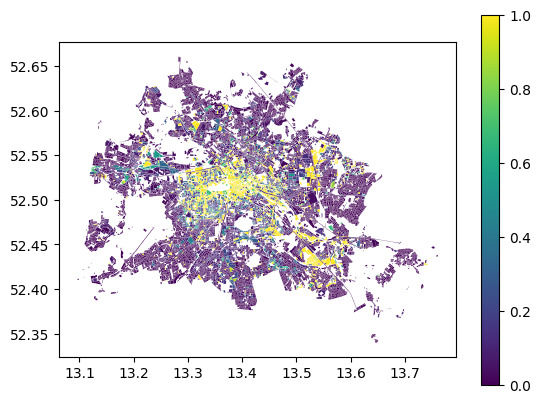

In [22]:
# plotting predicted probabilities
df_vis.plot(column = 'green_roof_pred_thresh', cmap = 'viridis', legend = True);

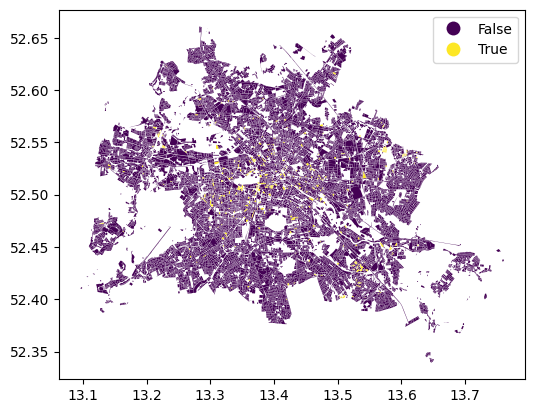

In [23]:
# plotting real green roofs situation
df_vis.plot(column = 'green_roof', cmap = 'viridis', legend = True);

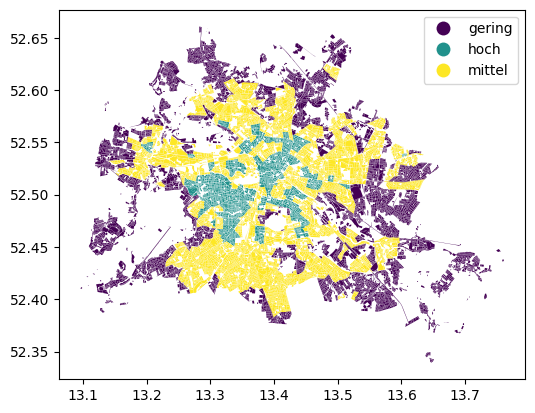

In [25]:
# plotting air pollution
df_vis.plot(column = 'air_pollution', cmap = 'viridis', legend = True);

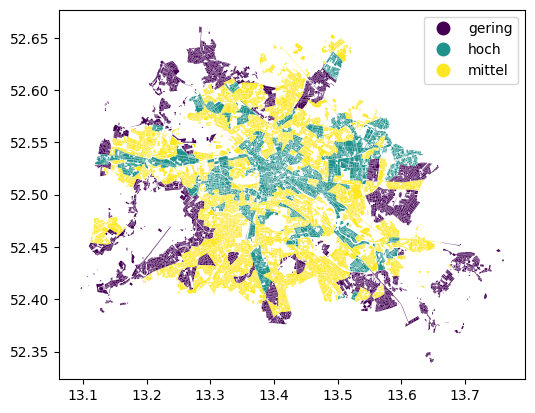

In [26]:
# plotting thremal stress
df_vis.plot(column = 'thermal_stress', cmap = 'viridis', legend = True);